In [19]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import Loss
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

In [20]:
tfd = tfp.distributions
# run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
tf.random.set_seed(42)

In [21]:
class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        initializer = tf.keras.initializers.GlorotNormal(seed=42)
        self.dense1 = Dense(500, activation='relu', kernel_initializer=initializer)
        self.dense2 = Dense(500, activation='relu', kernel_initializer=initializer)
        self.dense3 = Dense(128, activation='relu', kernel_initializer=initializer)
        self.dense4 = Dense(latent_dim, activation='softplus', kernel_initializer=initializer)

    def sample(self, alpha_hat, alpha, beta):
        shape = (alpha_hat.get_shape().as_list()[-2],alpha_hat.get_shape().as_list()[-1])
        u = tf.random.uniform(shape=shape, minval=0, maxval=1)
        v = tf.math.multiply(u,alpha)
        v = tf.math.multiply(v, tf.math.exp(tf.math.lgamma(alpha)))
        v = tf.math.pow(v, tf.math.divide(1.0,alpha))
        v = tf.math.divide(v,beta)
        z = tf.math.divide(v,tf.math.reduce_sum(v)) #sum to one
        #z ,_= tf.linalg.normalize(v)

        return z, v

    def call(self, inputs):
        x = inputs[0]
        alpha = inputs[1]
        beta = inputs[2]
        #x = tf.reshape(x, (-1,28*28))
        alpha_hat = self.dense1(x)
        alpha_hat = self.dense2(alpha_hat)
        #alpha_hat = self.dense3(alpha_hat)
        alpha_hat = self.dense4(alpha_hat)
        z, v = self.sample(alpha_hat, alpha, beta)
        return z, alpha_hat, v

In [22]:
class Decoder(Model):
    def __init__(self, original_shape):
        super(Decoder, self).__init__()
        initializer = tf.keras.initializers.GlorotNormal(seed=42)
        self.dense1 = Dense(500, activation='relu',kernel_initializer=initializer)
        self.dense2 = Dense(256, activation='relu',kernel_initializer=initializer)
        self.dense3 = Dense(512, activation='relu',kernel_initializer=initializer)
        self.dense4 = Dense(original_shape, activation='sigmoid',kernel_initializer=initializer)

    def call(self, x):
        x_hat = self.dense1(x)
        #x_hat = self.dense2(x_hat)
        #x_hat = self.dense3(x_hat)
        x_hat = self.dense4(x_hat)
        #x_hat = tf.reshape(x_hat,[-1,28,28])
        return x_hat

In [23]:
class DirVAE(Model):
    def __init__(self, latent_dim, original_dim):
        super(DirVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(original_dim)

    def compile(self, optimizer, loss):
        super().compile(optimizer)
        self.loss = loss

    def call(self, inputs):
        z, alpha_hat, v = self.encoder(inputs)
        x_hat = self.decoder(z)
        return x_hat, z, alpha_hat, v

In [24]:
@tf.function
def ELBO(log_likelihood_loss, y_pred, y_true, alpha, alpha_hat):
    ll_loss = log_likelihood_loss(y_true, y_pred)

    kld_loss = tf.math.subtract(tf.math.lgamma(alpha), tf.math.lgamma(alpha_hat))
    kld_loss = tf.math.add(kld_loss, tf.math.multiply(tf.math.subtract(alpha_hat, alpha),tf.math.digamma(alpha_hat)))
    kld_loss = tf.reduce_sum(kld_loss)

    return (tf.math.add(ll_loss, tf.math.maximum(0.0,kld_loss))), ll_loss, kld_loss

In [25]:
@tf.function
def update_alpha_mme(z, samples=1, epsilon=1e-13):
    
    epsilon = tf.convert_to_tensor(epsilon)
    dirichlet = tfd.Dirichlet(z)
    p_set = dirichlet.sample([samples])
    _, N, K = p_set.shape
    p_set = tf.reshape(p_set, (100,50,))

    mu1_tilde = tf.math.reduce_mean(p_set, axis=0)
    mu2_tilde = tf.math.reduce_mean(tf.math.pow(p_set,2), axis=0)

    S = tf.math.reduce_mean(tf.math.divide((tf.math.subtract(mu1_tilde, mu2_tilde)), (tf.math.subtract(mu2_tilde, tf.math.pow(mu1_tilde,2))) + epsilon), axis=0)

    alpha = tf.math.multiply(tf.math.divide(S,N), tf.math.reduce_sum(p_set, axis=0)) + epsilon

    return alpha

In [26]:
def ClipIfNotNone(grad):
            if grad is None:
                return grad
            return tf.clip_by_value(grad, -1000, 1000)

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
___________________________
_____EPOCH_0________
___________________________
Training loss at step 0: 682.2173
LL loss at step 0: 69.3147
kld loss at step 0: 612.9026

Training loss at step 250: 29.1864
LL loss at step 250: 26.6285
kld loss at step 250: 2.5579

Training loss at step 500: 25.8919
LL loss at step 500: 24.9261
kld loss at step 500: 0.9658

AVERAGE VALIDATION LOSS: 27.61255

RECONSTRUCTED


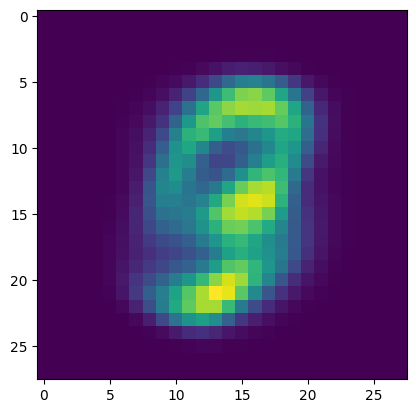


ORIGINAL


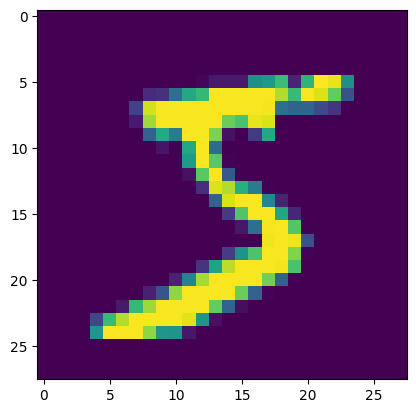

___________________________
_____EPOCH_1________
___________________________
Training loss at step 0: 26.9358
LL loss at step 0: 25.8011
kld loss at step 0: 1.1348

Training loss at step 250: 26.4471
LL loss at step 250: 25.7964
kld loss at step 250: 0.6508

Training loss at step 500: 26.4810
LL loss at step 500: 26.0240
kld loss at step 500: 0.4570

AVERAGE VALIDATION LOSS: 26.848866

___________________________
_____EPOCH_2________
___________________________
Training loss at step 0: 26.0777
LL loss at step 0: 25.6266
kld loss at step 0: 0.4511

Training loss at step 250: 26.3069
LL loss at step 250: 25.9379
kld loss at step 250: 0.3690

Training loss at step 500: 26.1107
LL loss at step 500: 25.8650
kld loss at step 500: 0.2456

AVERAGE VALIDATION LOSS: 26.568676

___________________________
_____EPOCH_3________
___________________________
Training loss at step 0: 25.7865
LL loss at step 0: 25.6264
kld loss at step 0: 0.1601

Training loss at step 250: 25.0221
LL loss at step 250: 2

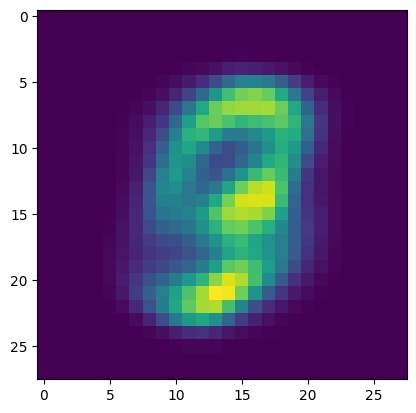


ORIGINAL


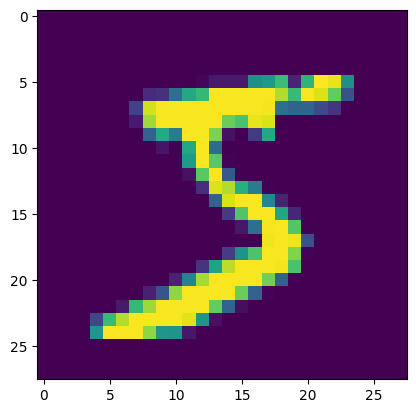

___________________________
_____EPOCH_11________
___________________________
Training loss at step 0: 26.4498
LL loss at step 0: 26.4478
kld loss at step 0: 0.0020

Training loss at step 250: 26.2874
LL loss at step 250: 26.2857
kld loss at step 250: 0.0018

Training loss at step 500: 26.1290
LL loss at step 500: 26.1272
kld loss at step 500: 0.0017

AVERAGE VALIDATION LOSS: 26.321926

___________________________
_____EPOCH_12________
___________________________
Training loss at step 0: 25.9159
LL loss at step 0: 25.9137
kld loss at step 0: 0.0022

Training loss at step 250: 25.8814
LL loss at step 250: 25.8797
kld loss at step 250: 0.0017

Training loss at step 500: 25.9002
LL loss at step 500: 25.8976
kld loss at step 500: 0.0027

AVERAGE VALIDATION LOSS: 26.322926

___________________________
_____EPOCH_13________
___________________________
Training loss at step 0: 26.6296
LL loss at step 0: 26.6279
kld loss at step 0: 0.0017

Training loss at step 250: 26.5130
LL loss at step 250

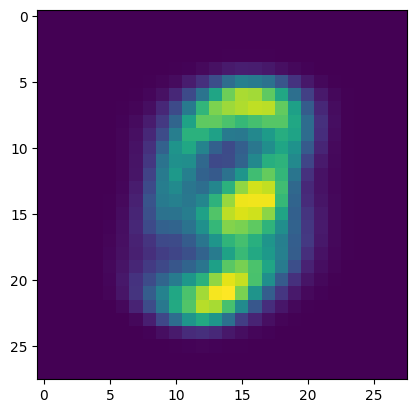


ORIGINAL


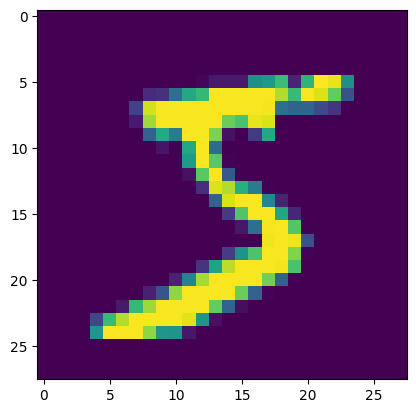

___________________________
_____EPOCH_21________
___________________________
Training loss at step 0: 31830.6934
LL loss at step 0: 25.3366
kld loss at step 0: 31805.3574

Training loss at step 250: 4065.8384
LL loss at step 250: 26.1337
kld loss at step 250: 4039.7046

Training loss at step 500: 3182.2053
LL loss at step 500: 25.8719
kld loss at step 500: 3156.3335

AVERAGE VALIDATION LOSS: 3593.5835

___________________________
_____EPOCH_22________
___________________________
Training loss at step 0: 3806.1870
LL loss at step 0: 27.1752
kld loss at step 0: 3779.0117

Training loss at step 250: 2693.1123
LL loss at step 250: 25.4767
kld loss at step 250: 2667.6357

Training loss at step 500: 1202.3584
LL loss at step 500: 26.0236
kld loss at step 500: 1176.3347

AVERAGE VALIDATION LOSS: 1411.3972

___________________________
_____EPOCH_23________
___________________________
Training loss at step 0: 2770.3137
LL loss at step 0: 25.6568
kld loss at step 0: 2744.6570

Training loss at 

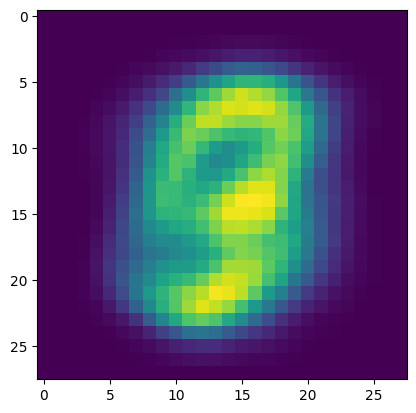


ORIGINAL


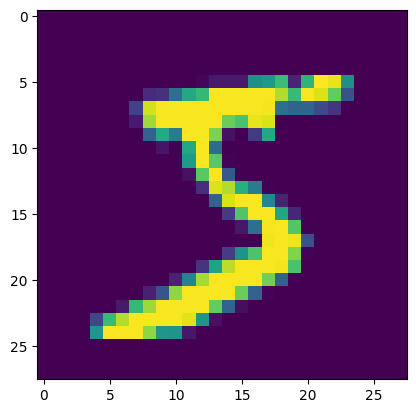

___________________________
_____EPOCH_31________
___________________________
Training loss at step 0: 54.0052
LL loss at step 0: 25.4632
kld loss at step 0: 28.5420

Training loss at step 250: 37.5731
LL loss at step 250: 27.0897
kld loss at step 250: 10.4834

Training loss at step 500: 36.0999
LL loss at step 500: 26.8100
kld loss at step 500: 9.2899

AVERAGE VALIDATION LOSS: 36.6969

___________________________
_____EPOCH_32________
___________________________
Training loss at step 0: 33.5907
LL loss at step 0: 25.7497
kld loss at step 0: 7.8409

Training loss at step 250: 36.0073
LL loss at step 250: 26.2804
kld loss at step 250: 9.7270

Training loss at step 500: 33.4978
LL loss at step 500: 25.8644
kld loss at step 500: 7.6334

AVERAGE VALIDATION LOSS: 32.4479

___________________________
_____EPOCH_33________
___________________________
Training loss at step 0: 31.7883
LL loss at step 0: 25.2477
kld loss at step 0: 6.5406

Training loss at step 250: 65.2878
LL loss at step 250: 

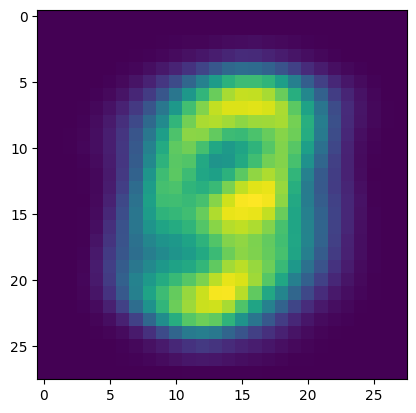


ORIGINAL


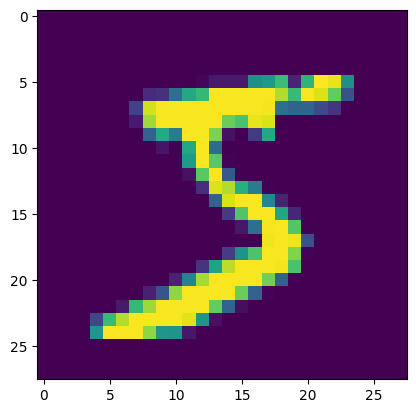

___________________________
_____EPOCH_41________
___________________________
Training loss at step 0: 1349808.7500
LL loss at step 0: 26.7110
kld loss at step 0: 1349782.0000

Training loss at step 250: 4655.5005
LL loss at step 250: 25.3609
kld loss at step 250: 4630.1396

Training loss at step 500: 1479.2054
LL loss at step 500: 27.1906
kld loss at step 500: 1452.0149

AVERAGE VALIDATION LOSS: 1054.4608

___________________________
_____EPOCH_42________
___________________________
Training loss at step 0: 855.0674
LL loss at step 0: 26.0243
kld loss at step 0: 829.0431

Training loss at step 250: 410.5324
LL loss at step 250: 25.8250
kld loss at step 250: 384.7074

Training loss at step 500: 283.3723
LL loss at step 500: 26.5696
kld loss at step 500: 256.8027

AVERAGE VALIDATION LOSS: 234.37277

___________________________
_____EPOCH_43________
___________________________
Training loss at step 0: 234.1343
LL loss at step 0: 25.3812
kld loss at step 0: 208.7531

Training loss at step

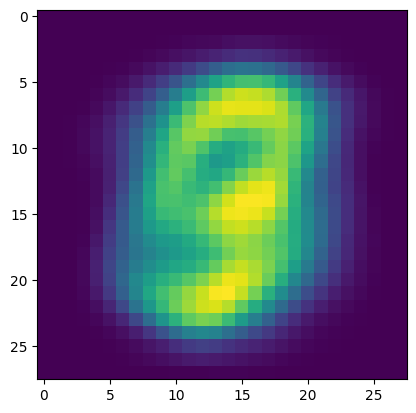


ORIGINAL


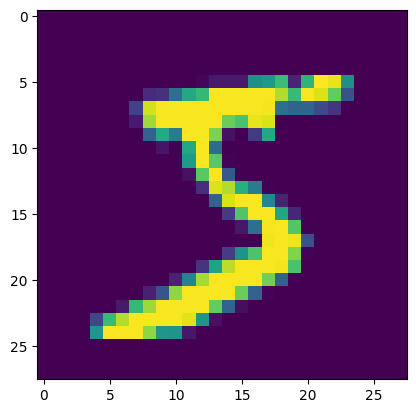

___________________________
_____EPOCH_51________
___________________________
Training loss at step 0: 30.4169
LL loss at step 0: 25.8453
kld loss at step 0: 4.5716

Training loss at step 250: 291.3328
LL loss at step 250: 25.9814
kld loss at step 250: 265.3514

Training loss at step 500: 39.4699
LL loss at step 500: 26.5894
kld loss at step 500: 12.8805

AVERAGE VALIDATION LOSS: 35.738895

___________________________
_____EPOCH_52________
___________________________
Training loss at step 0: 32.2799
LL loss at step 0: 25.5861
kld loss at step 0: 6.6939

Training loss at step 250: 44.7983
LL loss at step 250: 26.6047
kld loss at step 250: 18.1936

Training loss at step 500: 29.8092
LL loss at step 500: 25.1076
kld loss at step 500: 4.7016

AVERAGE VALIDATION LOSS: 31.316002

___________________________
_____EPOCH_53________
___________________________
Training loss at step 0: 32.0185
LL loss at step 0: 26.5594
kld loss at step 0: 5.4591

Training loss at step 250: 31.0973
LL loss at ste

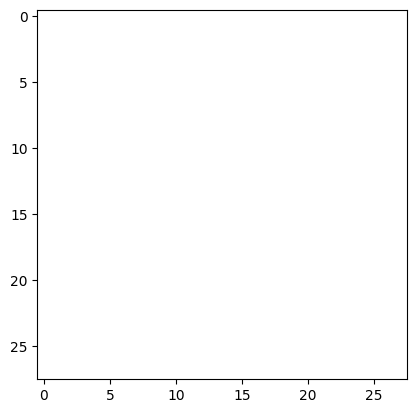


ORIGINAL


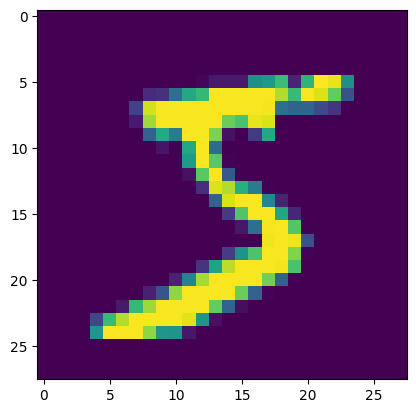

___________________________
_____EPOCH_61________
___________________________
Training loss at step 0: nan
LL loss at step 0: nan
kld loss at step 0: 35421.3789

Training loss at step 250: nan
LL loss at step 250: nan
kld loss at step 250: 62.4139



KeyboardInterrupt: 

In [27]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_reshaped = x_train.reshape((-1,28*28)).astype("float32") / 255
x_test_reshaped = x_test.reshape((-1,28*28)).astype("float32") / 255

print('GPU:', tf.config.list_physical_devices('GPU'))
tf.config.run_functions_eagerly(False)

latent_dim = 50
original_dim = 28*28

model = DirVAE(latent_dim, original_dim)

log_likelihood_loss = tf.keras.losses.BinaryCrossentropy(reduction='sum')
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

batch_size = 100
alpha = (1.0-(1.0/latent_dim)) * tf.ones((latent_dim,))
beta = 1.0 * tf.ones((latent_dim,))

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_reshaped))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_reshaped))
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

lowest_loss = np.inf
epochs = 1000
count = 0

# Training Loop with Gradient Accumulation and RAM Logging
for epoch in range(epochs):
    print('___________________________')
    print(f'_____EPOCH_{epoch}________')
    print('___________________________')
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            prediction, z, alpha_hat, v = model([x_batch_train, alpha, beta], training=True)
            loss_value, ll_loss, kld_loss = ELBO(log_likelihood_loss, prediction, x_batch_train, alpha, alpha_hat)

        grads = tape.gradient(loss_value, model.trainable_weights)
        grads = [ClipIfNotNone(grad) for grad in grads]
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        if step % 250 == 0:
            print(f"Training loss at step {step}: {float(loss_value):.4f}")
            print(f"LL loss at step {step}: {float(ll_loss):.4f}")
            print(f"kld loss at step {step}: {float(kld_loss):.4f}\n")


    val_loss = []
    for step, (x_batch_test) in enumerate(test_dataset):
        val_prediction, val_z, val_alpha_hat, val_v = model([x_batch_test, alpha, beta], training=False)
        val_loss_value, val_ll_loss, val_kld_loss = ELBO(log_likelihood_loss, val_prediction, x_batch_test, alpha, val_alpha_hat)
        val_loss.append(val_loss_value.numpy())
    val_loss = np.mean(np.array(val_loss))
    print('AVERAGE VALIDATION LOSS:', val_loss)
    print()

    ##UPDATE ALPHA
    if epoch % 20 == 0 and epoch != 0 and count <= 2:
        alpha = update_alpha_mme(z)
        print('Alpha:', alpha.numpy())
        count += 1
        
    if epoch % 10 == 0:
        inputs = [
            tf.convert_to_tensor(x_train[0].reshape((1,28*28))),
            alpha,
            beta
        ]

        image, img_z, img_alpha_hat, img_v = model(inputs)
        print("RECONSTRUCTED")
        plt.imshow(image[0].numpy().reshape((28,28)))
        plt.show()
        print()
        print("ORIGINAL")
        plt.imshow(x_train[0])
        plt.show()

    if val_loss_value.numpy() < lowest_loss:
        model.save_weights('my_model', overwrite=True, save_format='tf', options=None)
        lowest_loss = val_loss_value.numpy()

print('FINAL ALPHA:', alpha.numpy())
FINAL_ALPHA = alpha

In [ ]:
# z = tf.random.uniform(shape=(100,50), minval=1, maxval=10)
# #z = tf.math.divide(z, tf.math.reduce_sum(z))
# samples=1
# dirichlet = tfd.Dirichlet(z)
# p_set = dirichlet.sample([samples])
# print('p_set', p_set)
# _, N, K = p_set.shape

# p_set = tf.reshape(p_set, (100,50,))
# print('p_set shape', p_set.shape)

# mu1_tilde = tf.math.reduce_mean(p_set, axis=0)
# mu2_tilde = tf.math.reduce_mean(tf.math.pow(p_set,2), axis=0)

# print('mu1tilde shape', mu1_tilde.shape)
# print('mu2tilde shape', mu2_tilde.shape)

# S = tf.math.reduce_mean(tf.math.divide((tf.math.subtract(mu1_tilde, mu2_tilde)), (tf.math.subtract(mu2_tilde, tf.math.pow(mu1_tilde,2)))), axis=0)
# print('s shape', S.shape)
# alpha = tf.math.multiply(tf.math.divide(S,N), tf.math.reduce_sum(p_set, axis=0))
# print('alpha shape', alpha.shape)

In [ ]:
alpha